# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Importing-libraries" data-toc-modified-id="Importing-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importing libraries</a></div><div class="lev1 toc-item"><a href="#Reading-the-data-from-HDF5-files" data-toc-modified-id="Reading-the-data-from-HDF5-files-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reading the data from HDF5 files</a></div><div class="lev1 toc-item"><a href="#Aggregating-data" data-toc-modified-id="Aggregating-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Aggregating data</a></div><div class="lev1 toc-item"><a href="#Plotting-the-data" data-toc-modified-id="Plotting-the-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plotting the data</a></div><div class="lev2 toc-item"><a href="#Getting-correct-labels" data-toc-modified-id="Getting-correct-labels-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Getting correct labels</a></div><div class="lev2 toc-item"><a href="#Plotting-with-interaction" data-toc-modified-id="Plotting-with-interaction-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Plotting with interaction</a></div><div class="lev1 toc-item"><a href="#Plotting-on-aggregated-data" data-toc-modified-id="Plotting-on-aggregated-data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plotting on aggregated data</a></div>

# Importing libraries

In [1]:
%load_ext watermark
%watermark -v -m -a "Lilian Besson"

Lilian Besson 

CPython 3.6.7
IPython 7.4.0

compiler   : GCC 8.2.0
system     : Linux
release    : 4.15.0-47-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [2]:
import glob
import numpy as np
import h5py

In [43]:
%matplotlib notebook
from ipywidgets import interact, interactive

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns
sns.set(context="notebook", style="whitegrid", palette="hls", font="sans-serif", font_scale=1.2)

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 6)

# Reading the data from HDF5 files

In [5]:
ls *.hdf5

  main____env1-1_2716882551370202609.hdf5
  main____env1-1_4160622049092002586.hdf5
  main____env1-1_6913446395378684005.hdf5
  main____env1-1_7596928478056724205.hdf5
  main____env1-1_7874177522614843901.hdf5
  main____env1-1_8822290298029221465.hdf5
  main____env1-1_8907306919980792256.hdf5
  main____env1-1_9148946072941587600.hdf5


In [6]:
list_of_files = glob.glob("*.hdf5")

In [7]:
nbOfFiles = len(list_of_files)
print(f"There is {nbOfFiles} files")

There is 8 files


In [8]:
dict_of_files = {
    itspath: h5py.File(itspath)
    for itspath in list_of_files
}

In [10]:
nbPolicies = (list(dict_of_files.values()))[0].attrs['nbPolicies']
print(f"There is {nbPolicies} policies")

There is 16 policies


# Aggregating data

In [11]:
palette = sns.hls_palette(nbPolicies + 1)[:nbPolicies]

In [12]:
allmarkers = ['o', 'D', 'v', 'p', '<', 's', '^', '*', 'h', '>']
longlist = allmarkers * (1 + int(nbPolicies / float(len(allmarkers))))  # Cycle the good number of time
markers = longlist[:nbPolicies]  # Truncate

In [13]:
Ks, Ts = [], []
regrets, times, memories = [], [], []
map_of_KT_to_fileId = {}

for fileId, file in enumerate(list(dict_of_files.values())):
    T = file.attrs['horizon']
    env = file['env_0']
    K = env.attrs['nbArms']
    Ks.append(K)
    Ts.append(T)
    map_of_KT_to_fileId[(K, T)] = fileId

    one_regrets = np.mean(env['lastRegrets'], axis=1)
    regrets.append(one_regrets)
    one_times = np.mean(env['memoryConsumption'], axis=1)
    times.append(one_times)
    one_memories = np.mean(env['runningTimes'], axis=1)
    memories.append(one_memories)

In [16]:
values_of_K = sorted(list(set(Ks)))
print(f"The simulations explored different values of K : {values_of_K}")
values_of_T = sorted(list(set(Ts)))
print(f"The simulations explored different values of T : {values_of_T}")

The simulations explored different values of K : [2, 4, 8]
The simulations explored different values of T : [1000, 2500]


# Plotting the data

## Getting correct labels

In [12]:
labels = [f"Algorithm #{policyId + 1}" for policyId in range(nbPolicies) ]

In [13]:
labels = [
    r'$\varepsilon$-Greedy',
    'Explore-then-Commit',
    'Exp3++',
    'UCB',
    'kl-UCB',
    'Thompson',
    'BayesUCB',
    'AdBandits',
    'BESA',
    'MOSS-Anytime',
    'ApprFHG',
    r'UCB$\dagger$',
    'kl-UCB-switch',
    'Tsallis-Inf',
    'RCB',
    'PHE'
]

We can read the labels from the files:

In [39]:
labels = [ label.decode('utf8') for label in file.attrs['labels'].tolist() ]
import re
labels = [ re.sub(r"\(.*\)", "", label) for label in labels ]

In [40]:
print(f"Using labels = {labels}")

Using labels = ['EpsilonDecreasing', 'ETC_KnownGap', 'Exp3++', 'UCB', 'kl-UCB', 'Thompson', 'BayesUCB', 'AdBandits', 'BESA', 'MOSS-Anytime', 'ApprFHG', 'UCB$\\dagger$', 'kl-UCB-switch', 'Tsallis-Inf', 'RCB', 'PHE']


## Plotting with interaction

In [60]:
def plot_for_one_fileId(K=None, T=None,
                        logx=True, logy=True,
                        what_to_plot="regret_vs_time"):
    ax.clear()
    
    fileId = 0
    if (K, T) in map_of_KT_to_fileId:
            fileId = map_of_KT_to_fileId[(K, T)]
    K, T = Ks[fileId], Ts[fileId]
    
    one_times = times[fileId]
    one_memories = memories[fileId]
    one_regrets = regrets[fileId]

    #plt.scatter(one_times, one_memories, s=one_regrets, color=palette, alpha=0.7)
    for policyId in range(nbPolicies):
        one_time = one_times[policyId]
        one_memorie = one_memories[policyId]
        one_regret = one_regrets[policyId]
        color = palette[policyId]
        marker = markers[policyId]
        label = labels[policyId]
        if what_to_plot == "regret_vs_time":
            y = one_regret
            x = one_time
        if what_to_plot == "regret_vs_memory":
            y = one_regret
            x = one_memorie
        if what_to_plot == "memory_vs_time":
            y = one_memorie
            x = one_time
        if logx: x = np.log(x)
        if logy: y = np.log(y)
        ax.plot(x, y, ms=12, color=color, marker=marker, label=label, alpha=0.8)

    fig.tight_layout(rect=[0.04, 0.04, 0.75, 0.92])
    plt.legend(loc='center left', numpoints=1, fancybox=True, framealpha=0.8, bbox_to_anchor=(1, 0.5))

    if what_to_plot == "regret_vs_time":
        plt.xlabel(f"Running time in milli seconds {'(log scale)' if logx else ''}")
        plt.ylabel(f"Mean regret {'(log scale)' if logy else ''}")
    if what_to_plot == "regret_vs_memory":
        plt.xlabel(f"Memory consumption in bytes {'(log scale)' if logx else ''}")
        plt.ylabel(f"Mean regret {'(log scale)' if logy else ''}")
    if what_to_plot == "memory_vs_time":
        plt.xlabel(f"Running time in milli seconds {'(log scale)' if logx else ''}")
        plt.ylabel(f"Memory consumption in bytes {'(log scale)' if logy else ''}")
    plt.title(f"{nbPolicies} different algorithms\nBernoulli problem with K = {K} arms and horizon T = {T}")

    plt.draw()

<IPython.core.display.Javascript object>


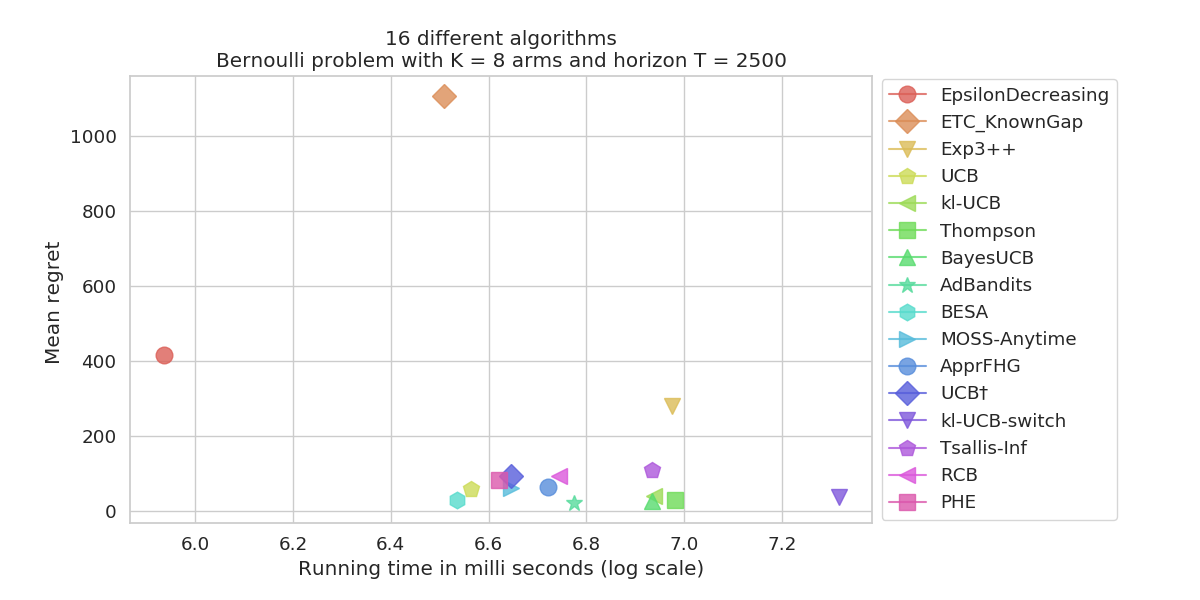

Plot was generated correctly...


In [51]:
fig, ax = plt.subplots()
plt.show()
plot_for_one_fileId()
plt.show()
print("Plot was generated correctly...")

In [52]:
interactive_plot = interactive(plot_for_one_fileId,
                               #fileId=(0, nbOfFiles-1),
                               what_to_plot=["regret_vs_time", "regret_vs_memory", "memory_vs_time"],
                               K=values_of_K,
                               T=values_of_T,
                               logx=False, logy=False,
)
display(interactive_plot)
plt.show()

interactive(children=(Dropdown(description='K', options=(2, 4, 8), value=None), Dropdown(description='T', opti…

# Plotting on aggregated data

In [53]:
np.array(times).shape

(8, 16)

In [62]:
def plot_for_aggregated_data(logx=True, logy=True,
                             what_to_plot="regret_vs_time"):
    ax.clear()
    
    mean_times = np.mean(np.array(times), axis=0)
    mean_memories = np.mean(np.array(memories), axis=0)
    mean_regrets = np.mean(np.array(regrets), axis=0)

    #plt.scatter(one_times, one_memories, s=one_regrets, color=palette, alpha=0.7)
    for policyId in range(nbPolicies):
        one_time = mean_times[policyId]
        one_memorie = mean_memories[policyId]
        one_regret = mean_regrets[policyId]
        color = palette[policyId]
        marker = markers[policyId]
        label = labels[policyId]
        if what_to_plot == "regret_vs_time":
            y = one_regret
            x = one_time
        if what_to_plot == "regret_vs_memory":
            y = one_regret
            x = one_memorie
        if what_to_plot == "memory_vs_time":
            y = one_memorie
            x = one_time
        if logx: x = np.log(x)
        if logy: y = np.log(y)
        ax.plot(x, y, ms=12, color=color, marker=marker, label=label, alpha=0.8)

    fig.tight_layout(rect=[0.04, 0.04, 0.75, 0.92])
    plt.legend(loc='center left', numpoints=1, fancybox=True, framealpha=0.8, bbox_to_anchor=(1, 0.5))

    if what_to_plot == "regret_vs_time":
        plt.xlabel(f"Running time in milli seconds {'(log scale)' if logx else ''}")
        plt.ylabel(f"Mean regret {'(log scale)' if logy else ''}")
    if what_to_plot == "regret_vs_memory":
        plt.xlabel(f"Memory consumption in bytes {'(log scale)' if logx else ''}")
        plt.ylabel(f"Mean regret {'(log scale)' if logy else ''}")
    if what_to_plot == "memory_vs_time":
        plt.xlabel(f"Running time in milli seconds {'(log scale)' if logx else ''}")
        plt.ylabel(f"Memory consumption in bytes {'(log scale)' if logy else ''}")
    plt.title(f"{nbPolicies} different algorithms\nmean results from {len(values_of_K) * len(values_of_T)} different Bernoulli problems\nwith different number of arms $K = {values_of_K}$\nand different horizons $T = {values_of_T}$")

    plt.draw()

<IPython.core.display.Javascript object>


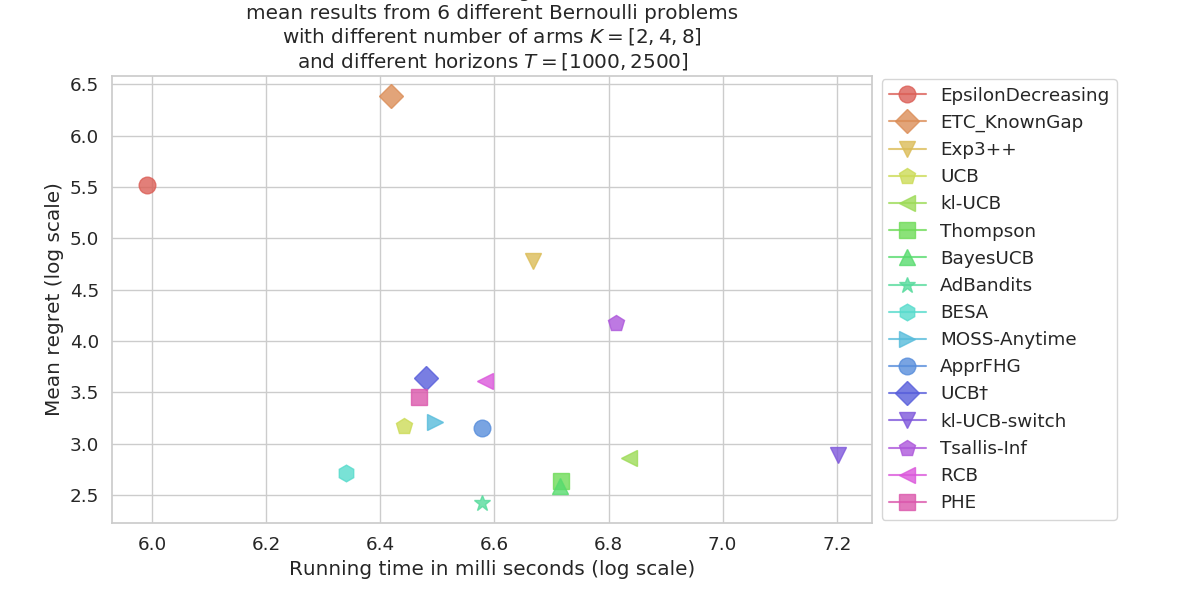

Plot was generated correctly...


In [63]:
fig, ax = plt.subplots()
plt.show()
plot_for_aggregated_data()
plt.show()
print("Plot was generated correctly...")

In [64]:
interactive_plot = interactive(plot_for_aggregated_data,
                               what_to_plot=["regret_vs_time", "regret_vs_memory", "memory_vs_time"],
                               logx=False, logy=False,
)
display(interactive_plot)
plt.show()

interactive(children=(Checkbox(value=False, description='logx'), Checkbox(value=False, description='logy'), Dr…